## Notebook Description

This notebook presents features used from PyTorch. They include but are not limited to TensorBoard, `named_children` and hooks for modules.

## Loading Modules and Data

We will use MNIST dataset for a demo of tensorboard and hooks.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

torch.manual_seed(0)
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Let us plot several pictures.

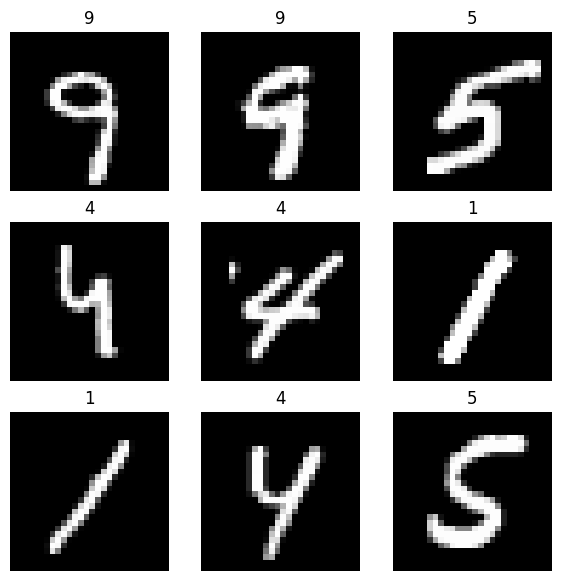

In [3]:
fig, axes = plt.subplots(3,3, figsize=(7,7))

for i, j in [(i,j) for i in range(3) for j in range(3)]:
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    axes[i, j].set_title(label)
    axes[i, j].axis('off')
    axes[i, j].imshow(img[0], vmin=0, vmax=1, cmap='grey')

## TensorBoard

TensorBoard is a tool developed by TensorFlow team. PyTorch gives access to limited subset of its features. One of the benefits of tensorboard over MatPlotLib is builtin ability to update plots online. Same behaviour can be reached for MatPlotLib, but it requires redrawing figure or axis. To access TensorBoard off Jupyter IDE you must have tensorboard python module installed, then run `tensorboard --logdir runs` in `tutorials` directory.

TensorBoard can be manipulated by `SummaryWriter`. TensorBoard saves all data and plots persistantly into folder by default it is `runs`.

In [4]:
from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np

writer = SummaryWriter()

`SummaryWriter` has many methods to interact with the board. Here we will note two most significant ones `add_scalar` and `add_figure`, the first adds a numeric value to tag and the second adds a matplotlib figure. Tags are a way to organize TensorBoard, they follow two-storey hierarchy with slash sign as a delimiter. TensorBoard also autonomously adds timestamps to all records made on it and provides a filter to control what shall be displayed, so keeping track of your progress is very straughtforward.

Bellow are examples of plotting simple functions, stochastic noise and a figure from above onto the board.

In [5]:
for i in range(10):
    writer.add_scalar('Det/Linear', i, i)
    writer.add_scalar('Det/Quad', i**2 - 4*i, i)
    writer.add_scalar('Stoch/np.random', np.random.random(), i)

In [6]:
fig, axes = plt.subplots(3,3, figsize=(7,7))

for i, j in [(i,j) for i in range(3) for j in range(3)]:
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    axes[i, j].set_title(label)
    axes[i, j].axis('off')
    axes[i, j].imshow(img[0])

writer.add_figure('EDA', fig)
plt.close(fig)

TensorBoard can be viewed from within the Jupyter notebook.

In [7]:
%load_ext tensorboard
%tensorboard --logdir runs

## Named Children & Hooks in PyTorch

One of the executives principles of Monitorch is ease of use in already established code. We try to achieve it by leverging frameworks tools such as hooks and module children.

Hooks are callbacks that are called whenever forward or bacward pass goes through the module. Methods `children` and `named_children` return iterator of submodules directly cotained in the module.

Below we create several instances of neural networks and prepare data to train neural net.

In [8]:
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=32, shuffle=True)

Here we define a convolutional neural net, its submodules will be only layers that have state, that is, linear or dropout. Activation layers are used in functionval style.

In [9]:
import torch.nn.functional as F

class MyNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1    = nn.Conv2d(1, 16,  kernel_size=3)
        self.conv2    = nn.Conv2d(16, 64, kernel_size=3)
        self.dropout2 = nn.Dropout(0.4)
        self.lin1     = nn.Linear(24*24*64, 128)
        self.lin2     = nn.Linear(128, 10)

    def forward(self, X):
        t = F.relu(self.conv1(X))
        t = self.dropout2(F.relu(self.conv2(t)))
        t = t.flatten(start_dim=1)
        t = F.relu(self.lin1(t))
        t = F.softmax(self.lin2(t), dim=1)
        return t

Then we proceed by instantiating our custom CNN and we also create two more feed-forward networks for demonstration purposes.

In [10]:
mynet = MyNet()

ffn = nn.Sequential(
    nn.Flatten(),

    nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
    ),

    nn.BatchNorm1d(512),
    nn.Sequential(
        nn.Linear(512, 512),
        nn.ReLU(),
    ),

    nn.BatchNorm1d(512),
    nn.Sequential(
        nn.Linear(512, 512),
        nn.ReLU(),
    ),

    nn.Sequential(
        nn.Linear(512, 10),
        nn.Softmax(dim=1),
    ),
)

small = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 10),
    nn.ReLU(),

    nn.Linear(10, 10),
    nn.Softmax(dim=1)
)

### Hooks

PyTorch provides four callbacks' (hooks') flavour, differentiating between forward and backwards hooks (run on forward and backward pass respectivly) and ordinary and pre- hooks (run after and before the pass).

Here we define two simple hooks to print out number of zeros in input and output during forward pass and to display norms of gradients on backward pass.

In [11]:
@torch.no_grad
def fw_hook(module, args, output) -> None:
    input = args[0]
    print(f"Zeros in input:  {(input == 0).float().mean():.3%}")
    print(f"Zeros in output: {(output == 0).float().mean():.3%}")

@torch.no_grad
def bw_hook(module, grad_input, grad_output):
    inp_norm = torch.mean(torch.tensor([torch.linalg.norm(grad) for grad in grad_input])).item() if grad_input[0] is not None else float('nan')
    out_norm = torch.mean(torch.tensor([torch.linalg.norm(grad) for grad in grad_output])).item()
    print(f"Mean input norm  {inp_norm:.3f}")
    print(f"Mean output norm {out_norm:.3f}")

We will register the hooks on `small` network and run one forward and backward pass.

In [12]:
fw_handle = small.register_forward_hook(fw_hook)
bw_handle = small.register_full_backward_hook(bw_hook)

In [13]:
x, y = next(iter(train_loader))
pred = small(x)

Zeros in input:  80.074%
Zeros in output: 0.000%


In [14]:
loss = F.cross_entropy(pred, y)
loss.backward()

Mean input norm  nan
Mean output norm 0.168


Note that there is no gradient of whole net, because input to this module are data, so they have no gradient. To compute gradient of hidden layers we must use `children` method.

To get rid of hooks we need to call `remove` from the handle returned by hook's registration.

In [15]:
fw_handle.remove()
bw_handle.remove()

pred = small(x)

loss = F.cross_entropy(pred, y)
loss.backward()

### Child modules

Children methods return iterators to all direct containees of parent container. For customly defined networks, such us above described `MyNet`, superclass `nn.Module` manages submodule registration during object's construction. Therefore any effects applied functionally will not be recorded and must be treated differently.

In [16]:
for name, child in mynet.named_children():
    print(name, '->', child)

conv1 -> Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
conv2 -> Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
dropout2 -> Dropout(p=0.4, inplace=False)
lin1 -> Linear(in_features=36864, out_features=128, bias=True)
lin2 -> Linear(in_features=128, out_features=10, bias=True)


In [17]:
for name, child in ffn.named_children():
    print(name, '->', child)

0 -> Flatten(start_dim=1, end_dim=-1)
1 -> Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
)
2 -> BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
3 -> Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
)
4 -> BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
5 -> Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
)
6 -> Sequential(
  (0): Linear(in_features=512, out_features=10, bias=True)
  (1): Softmax(dim=1)
)


Let us define backward and forward hook that will print information not only about its arguments, but also the module that have called it.

In [18]:
def named_fw_hook(name):
    def f(module, args, out):
        inp = args[0]
        print(f"(fw) {name}: Neuron activation {(out != 0).float().mean():.3%}")
    return f

def named_bw_hook(name):
    def f(module, grad_input, grad_output):
        inp_norm = torch.mean(torch.tensor([torch.linalg.norm(grad) for grad in grad_input])).item() if grad_input[0] is not None else float('nan')
        out_norm = torch.mean(torch.tensor([torch.linalg.norm(grad) for grad in grad_output])).item()
        print(f"(bw) {name}: Mean input norm  {inp_norm:.3g}")
        print(f"(bw) {name}: Mean output norm {out_norm:.3g}")
        pass
    return f

In [19]:
for name, child in mynet.named_children():
    child.register_full_backward_hook(named_bw_hook(name))
    child.register_forward_hook(named_fw_hook(name))

Let us do One forward and one bacward pass

In [20]:
x, y = next(iter(train_loader))
r = mynet(x)

(fw) conv1: Neuron activation 100.000%
(fw) conv2: Neuron activation 100.000%
(fw) dropout2: Neuron activation 30.933%
(fw) lin1: Neuron activation 100.000%
(fw) lin2: Neuron activation 100.000%


In [21]:
F.cross_entropy(r, y).backward()

(bw) lin2: Mean input norm  0.00986
(bw) lin2: Mean output norm 0.0166
(bw) lin1: Mean input norm  0.0041
(bw) lin1: Mean output norm 0.0071
(bw) dropout2: Mean input norm  0.00529
(bw) dropout2: Mean output norm 0.0041
(bw) conv2: Mean input norm  0.00218
(bw) conv2: Mean output norm 0.0038
(bw) conv1: Mean input norm  nan
(bw) conv1: Mean output norm 0.00136


Next we will train our network for 5 batch-iterations with hooks installed.

In [22]:
from itertools import islice

optimizer = torch.optim.NAdam(
    mynet.parameters()
)
for data, labels in islice(train_loader, 5):
    print('New iteration')
    optimizer.zero_grad()
    pred = mynet(data)
    loss = F.cross_entropy(pred, labels)
    loss.backward()
    optimizer.step()
        

New iteration
(fw) conv1: Neuron activation 100.000%
(fw) conv2: Neuron activation 100.000%
(fw) dropout2: Neuron activation 31.011%
(fw) lin1: Neuron activation 100.000%
(fw) lin2: Neuron activation 100.000%
(bw) lin2: Mean input norm  0.00996
(bw) lin2: Mean output norm 0.017
(bw) lin1: Mean input norm  0.00415
(bw) lin1: Mean output norm 0.00719
(bw) dropout2: Mean input norm  0.00536
(bw) dropout2: Mean output norm 0.00415
(bw) conv2: Mean input norm  0.00222
(bw) conv2: Mean output norm 0.00386
(bw) conv1: Mean input norm  nan
(bw) conv1: Mean output norm 0.00139
New iteration
(fw) conv1: Neuron activation 100.000%
(fw) conv2: Neuron activation 100.000%
(fw) dropout2: Neuron activation 30.014%
(fw) lin1: Neuron activation 100.000%
(fw) lin2: Neuron activation 100.000%
(bw) lin2: Mean input norm  0.0143
(bw) lin2: Mean output norm 0.0242
(bw) lin1: Mean input norm  0.00841
(bw) lin1: Mean output norm 0.0102
(bw) dropout2: Mean input norm  0.0109
(bw) dropout2: Mean output norm 0.00

We have obtained a mass of data, let us try it on even deeper net.

In [23]:
for name, child in ffn.named_children():
    child.register_full_backward_hook(named_bw_hook(name))
    child.register_forward_hook(named_fw_hook(name))

optimizer = torch.optim.NAdam(
    ffn.parameters()
)

for data, labels in islice(train_loader, 5):
    print('New iteration')
    optimizer.zero_grad()
    pred = ffn(data)
    loss = F.cross_entropy(pred, labels)
    loss.backward()
    optimizer.step()

New iteration
(fw) 0: Neuron activation 18.355%
(fw) 1: Neuron activation 51.453%
(fw) 2: Neuron activation 98.633%
(fw) 3: Neuron activation 50.043%
(fw) 4: Neuron activation 100.000%
(fw) 5: Neuron activation 50.201%
(fw) 6: Neuron activation 100.000%
(bw) 6: Mean input norm  0.00961
(bw) 6: Mean output norm 0.168
(bw) 5: Mean input norm  0.00395
(bw) 5: Mean output norm 0.00961
(bw) 4: Mean input norm  0.0123
(bw) 4: Mean output norm 0.00395
(bw) 3: Mean input norm  0.00504
(bw) 3: Mean output norm 0.0123
(bw) 2: Mean input norm  0.22
(bw) 2: Mean output norm 0.00504
(bw) 1: Mean input norm  nan
(bw) 1: Mean output norm 0.22
New iteration
(fw) 0: Neuron activation 17.877%
(fw) 1: Neuron activation 51.086%
(fw) 2: Neuron activation 100.000%
(fw) 3: Neuron activation 49.323%
(fw) 4: Neuron activation 100.000%
(fw) 5: Neuron activation 49.512%
(fw) 6: Neuron activation 100.000%
(bw) 6: Mean input norm  0.0157
(bw) 6: Mean output norm 0.166
(bw) 5: Mean input norm  0.0068
(bw) 5: Mean o

## Conclusion

This notebook shows technological foundations of Monitorch. The library adds a number of little machines and metrics to monitor neural network training efficiently.